## Import all what we need.

In [1]:
# encoding: utf-8
import os
import bz2
import csv
import glob
import time
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import njit
from io import StringIO
import matplotlib.pyplot as plt
import threading, multiprocessing

## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [2]:
#########################################################
inp_filepath = '/home/jingxin/PyExoCross/input/AlO_exomol.inp'
#########################################################

## Report time

In [3]:
class Timer:    
    def start(self):
        self.start_CPU = time.process_time()
        self.start_sys = time.time()
        return self

    def end(self, *args):
        self.end_CPU = time.process_time()
        self.end_sys = time.time()
        self.interval_CPU = self.end_CPU - self.start_CPU
        self.interval_sys = self.end_sys - self.start_sys
        print('{:25s} : {}'.format('Running time on CPU', self.interval_CPU), 's')
        print('{:25s} : {}'.format('Running time on system', self.interval_sys), 's')

## Read Information from Input File

In [4]:
def inp_para(inp_filepath, N_A):
    
    inp_col_name = ['c0','c1','c2','c3','c4','c5']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, usecols=[0,1,2,3,4,5], header=None)
    col0 = inp_df['c0']
    
    # Database
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    
    # Basic information
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    dataset = inp_df[col0.isin(['Dataset'])]['c1'].values
    mol_iso_id = int(inp_df[col0.isin(['mol_iso_id'])]['c1'])
    
    # File path
    read_path = inp_df[col0.isin(['ReadPath'])]['c1'].values[0]
    save_path = inp_df[col0.isin(['SavePath'])]['c1'].values[0]
    if os.path.exists(save_path):
        pass
    else:
        os.makedirs(save_path, exist_ok=True)
        
    # Functions 
    PartitionFunctions = int(inp_df[col0.isin(['PartitionFunctions'])]['c1'])
    CoolingFunctions = int(inp_df[col0.isin(['CoolingFunctions'])]['c1'])
    Lifetimes = int(inp_df[col0.isin(['Lifetimes'])]['c1'])
    SpecificHeats = int(inp_df[col0.isin(['SpecificHeats'])]['c1'])
    CrossSections = int(inp_df[col0.isin(['CrossSections'])]['c1'])
    
    # Calculate partition, cooling functions or specific heats 
    Ntemp = int(inp_df[col0.isin(['Ntemp'])]['c1'])    # The number of temperature steps
    Tmax = int(inp_df[col0.isin(['Tmax'])]['c1'])      # Maximal temperature in K (minimal T = 1 K )
     
     
    # Calculate lifetimes 
    # None
    

    # Calculate cross-sections 
    broadeners = list(inp_df[col0.isin(['Broadeners'])].iloc[0])[1:]
    ratios = np.array(list(inp_df[col0.isin(['Ratios'])].iloc[0])[1:], dtype=float)
    
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    P = float(inp_df[col0.isin(['Pressure'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    
    cutoff = float(inp_df[col0.isin(['Cutoff'])]['c1'])
    threshold = float(inp_df[col0.isin(['Threshold'])]['c1'])
    
    abs_emi = inp_df[col0.isin(['Absorption/Emission'])]['c1'].values[0]
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    

    molecule_id = int(mol_iso_id/10)
    isotopologue_id = mol_iso_id - molecule_id * 10
        
    if database == 'ExoMol':
        # Read ExoMol definition file (.def) to get the mass.
        deffile_path = (read_path+'/'+molecule+'/'+isotopologue+'/'+dataset+'/'+isotopologue+'__'+dataset+'.def')
        def_df = pd.read_csv(deffile_path[0],sep='\\s+',usecols=[0,1,2,3,4],names=['0','1','2','3','4'],header=None)
        abundance = 1
        mass_exomol = def_df[def_df['4'].isin(['mass'])]['0'].values[0]     # ExoMol mass (Da)
        mass = float(mass_exomol / N_A)
        check_uncertainty = int(def_df[def_df['2'].isin(['Uncertainty'])]['0'].values[0])
        check_lifetime = int(def_df[def_df['2'].isin(['Lifetime'])]['0'].values[0])
    elif database == 'HITRAN':
        isometa_url = 'https://hitran.org/docs/iso-meta/'
        iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
        iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
        abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
        mass_hitran = float(iso_meta_row['Molar Mass /g·mol-1'])            # HITRAN molar mass (g/mol)
        mass = float(mass_hitran / N_A)
        check_uncertainty = 0
        check_lifetime = 0
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    

    return (database, molecule, isotopologue, dataset, read_path, save_path, 
            PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, CrossSections,
            Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, cutoff, threshold, 
            abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass,
            check_uncertainty, check_lifetime)


## Constants and Parameters

In [5]:
# Parameters for calculating
import astropy.constants as ac
T_ref = 296.0                       # Reference temperature is 296 K
P_ref = 1.0                         # Reference pressure is 1 atm
N_A = ac.N_A.value                  # Avogadro number (1/mol)
h = ac.h.to('J s').value            # Planck's const (J s)
c = ac.c.to('cm/s').value           # Velocity of light (cm/s)
kB = ac.k_B.to('J/K').value         # Boltzmann's const (J/K)
R = ac.R.to('J / (K mol)').value    # Gas constant (J/(K mol))
c2 = h * c / kB                     # Second radiation constant (cm K)

(database, molecule, isotopologue, dataset, read_path, save_path, 
 PartitionFunctions, CoolingFunctions, Lifetimes, SpecificHeats, CrossSections,
 Ntemp, Tmax, broadeners, ratios, T, P, min_wn, max_wn, N_point, cutoff, threshold, 
 abs_emi, profile, wn_wl, molecule_id, isotopologue_id, abundance, mass, 
 check_uncertainty, check_lifetime) = inp_para(inp_filepath, N_A)

c2_T = c2 / T                       # c2 / T (cm)
c2_T_ref = c2 / T_ref               # c2 / T_ref (cm)
pi_c_8 = 1 / (8 * np.pi * c)        # 8 * pi * c (s/cm)

# Read Input Files

Read the parameters of the linelist in ExoMol or HITRAN format text file. Return the dataframe of the data for the following calculations.

## Read ExoMol Database Files

### Read States File

In [6]:
def read_all_states(read_path):
    
    s_df = dict()
    states_df = pd.DataFrame()
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])

    for states_filename in states_filenames:
        s_df[states_filename] = pd.read_csv(states_filename, compression='bz2', sep='\s+', header=None,
                                            chunksize=100000, iterator=True, low_memory=False, dtype=object)
        for chunk in s_df[states_filename]:
            states_df = pd.concat([states_df, chunk])
            
    pd.set_option("display.max_columns",30)                           
    return(states_df)

In [7]:
states_df = read_all_states(read_path)
states_df 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0.000000,12,0.5,0.000001,inf,+,e,X2SIGMA+,0,0,0.5,0.5,EH
1,2,965.416878,12,0.5,0.001651,3.6193e+01,+,e,X2SIGMA+,1,0,0.5,0.5,PS
2,3,1916.827286,12,0.5,0.010519,9.1761e+00,+,e,X2SIGMA+,2,0,0.5,0.5,PS
3,4,2854.162814,12,0.5,0.022148,4.2147e+00,+,e,X2SIGMA+,3,0,0.5,0.5,PS
4,5,3777.464572,12,0.5,0.019275,2.3874e+00,+,e,X2SIGMA+,4,0,0.5,0.5,PS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94857,94858,36579.866789,816,67.5,0.049029,NaN,-,e,C2PI,1,1,0.5,0.5,Ma
94858,94859,36659.627084,828,68.5,0.250000,NaN,+,e,C2PI,1,1,0.5,0.5,Ma
94859,94860,36659.916559,828,68.5,0.250000,NaN,-,f,C2PI,1,1,0.5,0.5,Ma
94860,94861,9295.408779,840,69.5,0.006859,NaN,-,e,X2SIGMA+,7,0,0.5,0.5,Ma


### Read transitions File

In [8]:
def get_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are three format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:        
            trans_filepaths.append(trans_filepaths_all[i])
    return(trans_filepaths)   

In [9]:
def read_all_trans(read_path):
    
    t_df = dict()
    trans_df = pd.DataFrame()
    trans_col_name = ['u', 'l', 'A', 'v']
    trans_filepaths = get_transfiles(read_path)

    for trans_filename in tqdm(trans_filepaths):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None,
                                           names=trans_col_name, chunksize=100000, iterator=True, low_memory=False)
        for chunk in t_df[trans_filename]:
            trans_df = pd.concat([trans_df,chunk])
            
    #pd.set_option("display.max_columns",30)                           
    return(trans_df)
    

In [10]:
all_trans_df = read_all_trans(read_path)
all_trans_df

100%|██████████| 1/1 [00:15<00:00, 15.83s/it]


,u,l,A,v
0,551,351,8.884200e-27,NaN
1,357,557,1.182800e-25,NaN
2,554,354,7.430600e-25,NaN
3,751,951,2.514000e-25,NaN
4,1351,1151,2.279000e-24,NaN
...,...,...,...,...
4945575,50740,50355,1.477900e-08,NaN
4945576,14938,14555,4.148300e-09,NaN
4945577,41938,41153,7.320000e-14,NaN
4945578,37141,36357,1.905400e-12,NaN


## Convert among the frequency, upper and lower state energy

In [11]:
@njit(parallel=True, fastmath=True)
def cal_v(Epp, Ep):
    v = np.abs(Epp - Ep)
    return(v)

In [12]:
@njit(parallel=True, fastmath=True)
def cal_Ep(Epp, v):
    Ep = np.abs(Epp + v)
    return(Ep)

### Read Partition Function File From ExoMol Database

In [13]:
def read_exomolweb_pf(T):
    
    pf_url = ('http://www.exomol.com/db/' + molecule + '/' + isotopologue + '/' + dataset 
              + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_content = requests.get(pf_url).text
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(StringIO(pf_content), sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]

    return(Q)

In [14]:
def read_exomol_pf(read_path, T):
    
    pf_filename = (read_path + molecule + '/' + isotopologue + '/' + dataset 
                   + '/' + isotopologue + '__' + dataset + '.pf')[0]
    pf_col_name = ['T', 'Q']
    pf_df = pd.read_csv(pf_filename, sep='\\s+', names=pf_col_name, header=None)
    Q = pf_df['Q'][T-1]

    return(Q)

### Read Broadening File

In [15]:
def read_broad(read_path):
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']
    broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__air.broad')[0]
    if not os.path.exists(broad_path):
        raise ImportError('The boradening file ' + broad_path + ' does not exist.')
    broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
    return(broad_df)

In [16]:
def read_broad(read_path):
    broad_col_name = ['code', 'gamma_L', 'n_air', 'Jpp']

    default_broad_df = pd.DataFrame(columns=broad_col_name)
    air_broad_df = pd.DataFrame(columns=broad_col_name)
    self_broad_df = pd.DataFrame(columns=broad_col_name)
    H2_broad_df = pd.DataFrame(columns=broad_col_name)
    He_broad_df = pd.DataFrame(columns=broad_col_name)

    broad = []
    ratio = []
    for i in range(len(ratios)):
        if ratios[i] != 0.0:
            if broadeners[i] == 'Default':
                default_gamma_L = 0.07
                default_n_air = 0.5
                default_broad_df = pd.DataFrame([['code', default_gamma_L, default_n_air,'Jpp']],columns=broad_col_name)
            if broadeners[i] == 'Air':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__air.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                air_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            if broadeners[i] == 'Self':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__self.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                self_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            if broadeners[i] == 'H2':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__H2.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                H2_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            if broadeners[i] == 'He':
                broad_path = (read_path + molecule + '/' + isotopologue + '/' + isotopologue + '__He.broad')[0]
                if not os.path.exists(broad_path):
                    raise ImportError('The boradening file ' + broad_path + ' does not exist.')    
                He_broad_df = pd.read_csv(broad_path, sep='\s+', names=broad_col_name, header=None, engine='python')
            
            broad.append(broadeners[i])
            ratio.append(ratios[i])
    print('Broadeners \t: ', broadeners[0],'\t',broadeners[1],'\t',broadeners[2],'\t',broadeners[3],'\t',broadeners[4])
    print('Ratios \t\t: ', ratios[0],'\t\t',ratios[1],'\t',ratios[2],'\t',ratios[3],'\t',ratios[4])
    return(broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df)        


## Read HITRAN Database Files

### Read HITRAN Linelist File

In [17]:
def read_hitran_parfile (read_path, parfile_df):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2020 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = read_path.split('/')[-1]
    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2020 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()
    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int32')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int32')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2}))
    hitran_df['A'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')             # The Einstein-A coefficient (s^{-1}) of a transition
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    #hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    #hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    #hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    #hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('float64')          # Statistical weight of the upper state
    
    hitran_df = hitran_df[hitran_df['M'].isin([molecule_id])]
    hitran_df = hitran_df[hitran_df['I'].isin([isotopologue_id])]
    hitran_df = hitran_df[hitran_df['v'].between(min_wn, max_wn)]
    hitran_df = hitran_df[hitran_df['S'] > threshold]
    
    return hitran_df


In [18]:
def read_parfile(read_path):
    if not os.path.exists(read_path):
        raise ImportError('The input file ' + read_path + ' does not exist.')

    # Initialise the iterator object.
    read_par = pd.read_csv(read_path, chunksize=10000, iterator=True, header=None, encoding='utf-8')
    par_df = pd.DataFrame()
    for chunk in read_par:
        par_df = pd.concat([par_df, chunk])
    return(par_df)

### Read Partition Function File From HITRANOnline

In [19]:
def read_hitran_pf(T):
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    #Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]   
    return(Q)

# Calculate Parition Function


In [20]:
@njit(parallel=True, fastmath=True)
def calculate_partition(En, gn, T):
    partition_func = np.sum(gn * np.exp(-c2 * En / T))
    return(partition_func)

In [21]:
# Partition function
def exomol_partition_func(read_path, states_df, Ntemp, Tmax):
    
    print('Calculate partition functions.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    En = states_df[1].astype('float').values
    gn = states_df[2].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    
    partition_func = [calculate_partition(En, gn, T) for T in Ts]
    
    partition_func_df = pd.DataFrame()
    partition_func_df['T'] = Ts
    partition_func_df['partition function'] = partition_func
        
    pf_folder = save_path + '/partition/'
    if os.path.exists(pf_folder):
        pass
    else:
        os.makedirs(pf_folder, exist_ok=True)
    pf_path = (pf_folder + isotopologue + '__' + dataset + '.pf')[0]
    np.savetxt(pf_path, partition_func_df, fmt="%8.1f %15.4f")
    
    t.end()
    print('Partition functions has been saved!\n')  


In [22]:
#Ntemp = 1
#Tmax = int(5000.00)

#exomol_partition_func(read_path, states_df, Ntemp, Tmax)

# Calculate Cooling Function

In [23]:
def linelist_coolingfunc(read_path, states_df, all_trans_df):
    #states_df = read_all_states(read_path)
    #all_trans_df = read_all_trans(read_path)
    id_u = all_trans_df['u'].values
    id_l = all_trans_df['l'].values
    states_df.set_index([0], inplace=True, drop=False)
    states_u_df = states_df.iloc[id_u-1]
    states_l_df = states_df.iloc[id_l-1]
    Ep = states_u_df[1].astype('float').values  # Lower state energy
    gp = states_u_df[2].astype('int').values  # Total degeneracy of lower state 
    A = all_trans_df['A'].values    # Einstein A-coefficient
    if pd.isna(all_trans_df['v'])[0] == False:
        v = all_trans_df['v'].values
    else:
        Epp = states_l_df[1].astype('float').values # Upper state energy
        v = cal_v(Ep, Epp) 
    return (A, v, Ep, gp)

In [24]:
@njit(parallel=True, fastmath=True)
def calculate_cooling(A, v, Ep, gp, T, Q):
    cooling_func = np.sum(A * h * c * v * gp * np.exp(-c2 * Ep / T)) / (4 * np.pi * Q) * 1e7
    return(cooling_func)

In [25]:
# Cooling function
def exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax):
    
    print('Calculate cooling functions.')  
    t = Timer()
    t.start()
    
    A, v, Ep, gp = linelist_coolingfunc(read_path, states_df, all_trans_df)
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    Qs = [read_exomol_pf(read_path, T) for T in Ts]
    
    cooling_func = [calculate_cooling(A, v, Ep, gp, T, Q) for T,Q in zip(Ts,Qs)]
    
    cooling_func_df = pd.DataFrame()
    cooling_func_df['T'] = Ts
    cooling_func_df['cooling function'] = cooling_func

    cf_folder = save_path + '/cooling/'
    if os.path.exists(cf_folder):
        pass
    else:
        os.makedirs(cf_folder, exist_ok=True)  
    cf_path = (cf_folder + isotopologue + '__' + dataset + '.cooling')[0]    
    np.savetxt(cf_path, cooling_func_df, fmt="%8.1f %20.8E")
    
    t.end()
    print('Cooling functions has been saved!\n')   

In [26]:
#Ntemp = 1
#Tmax = int(500.00)

#exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax)

# Lifetime

In [27]:
# Lifetime
def exomol_lifetime(read_path, states_df, all_trans_df):
    
    print('Calculate lifetimes.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    #all_trans_df = read_all_trans(read_path)
    sum_A = all_trans_df.groupby('u')['A'].sum()
    lifetime = 1 / sum_A
    lt_df = lifetime.map('{: >12.4E}'.format).reset_index()
    lt_df.columns=['u','lt']
    uid = lt_df['u']
    add_u = pd.DataFrame()
    add_u['u'] = pd.concat([states_df[0].astype('int'), uid]).drop_duplicates(keep=False)
    add_u['lt'] = '         inf'
    lifetime_df = pd.concat([lt_df, add_u], ignore_index=True)
    lifetime_df.sort_values('u',inplace=True)
    
    states_filenames = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset 
                                  + '/' + isotopologue + '__' + dataset + '.states.bz2')[0])
    s_df = pd.read_csv(states_filenames[0], compression='bz2', header=None, dtype=object)
    lifetime_list = list(lifetime_df['lt'])
    nrows = len(s_df)
    new_rows = []
    if check_uncertainty == 0:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:41]+lifetime_list[i]+s_df[0][i][53:]+'\n')
    if check_uncertainty == 1:
        for i in range(nrows):
            new_rows.append(s_df[0][i][:55]+lifetime_list[i]+s_df[0][i][67:]+'\n')

    lf_folder = save_path + '/lifetime/'
    if os.path.exists(lf_folder):
        pass
    else:
        os.makedirs(lf_folder, exist_ok=True)  
    lf_path = (lf_folder + isotopologue + '__' + dataset + '.states.bz2')[0]

    with bz2.open(lf_path, 'wt') as f:
        for i in range(nrows):
            f.write(new_rows[i])
        f.close

    t.end()
    print('Lifetimes has been saved!\n')   


In [28]:
#exomol_lifetime(read_path, states_df, all_trans_df)

# Specific Heat

In [29]:
@njit(parallel=True, fastmath=True)
def calculate_specific_heats(En, gn, T):
    pf = np.sum(gn * np.exp(-c2 * En / T))  
    pfp = np.sum(gn * np.exp(-c2 * En / T) * (c2 * En / T))
    pfpp = np.sum(gn * np.exp(-c2 * En / T) * (c2 * En / T) ** 2)
    specificheat_func = R * (pfpp / pf - (pfp / pf) ** 2) + 2.5 * R
    return(specificheat_func)

In [30]:
# Specific heat
def exomol_specificheat(read_path, states_df, Ntemp, Tmax):
    print('Calculate specific heats.')  
    t = Timer()
    t.start()
    
    #states_df = read_all_states(read_path)
    En = states_df[1].astype('float').values
    gn = states_df[2].astype('int').values
    Ts = np.array(range(Ntemp, Tmax+1, Ntemp)) 
    
    specificheat_func = [calculate_specific_heats(En, gn, T) for T in Ts]
    
    specificheat_func_df = pd.DataFrame()
    specificheat_func_df['T'] = Ts
    specificheat_func_df['specific heat'] = specificheat_func
        
    cp_folder = save_path + '/specific_heat/'
    if os.path.exists(cp_folder):
        pass
    else:
        os.makedirs(cp_folder, exist_ok=True)  
    cp_path = (cp_folder + isotopologue + '__' + dataset + '.cp')[0]
    np.savetxt(cp_path, specificheat_func_df, fmt="%8.1f %15.4f")

    t.end()
    print('Specific heats has been saved!\n')  


In [31]:
#Ntemp = 1
#Tmax = int(5000.0)

#exomol_specificheat(read_path, states_df, Ntemp, Tmax)


# Cross Section

## Process data for Calculating cross sections

In [32]:
def get_part_transfiles(read_path):
    # Get all the transitions files from the folder including the older version files which are named by vn(version number).
    trans_filepaths_all = glob.glob((read_path + molecule + '/' + isotopologue + '/' + dataset + '/' + '*trans.bz2')[0])
    num_transfiles_all = len(trans_filepaths_all)    # The number of all transitions files including the older version files.
    trans_filepaths = []    # The list of the lastest transitions files.
    for i in range(num_transfiles_all):
        split_version = trans_filepaths_all[i].split('__')[-1].split('.')[0].split('_')    # Split the filenames.
        num = len(split_version)
        # There are three format filenames.
        # The lastest transitions files named in two formats:
        # 1. Filenames are named with the name of isotopologue and dataset. 
        #    End with .trans.bz2.
        #    e.g. 14N-16O__XABC.trans.bz2'
        # 2. Filenames are named with the name of isotopologue and dataset. 
        #    Also have the range of wavenumbers xxxxx-yyyyy.
        #    End with .trans.bz2.
        #    e.g. 1H2-16O__POKAZATEL__00000-00100.trans.bz2
        # 3. The older version transitions files are named with vn(version number) based on the first format of the lastest files.
        #    e.g. 14N-16O__XABC_v2.trans.bz2
        # After split the filenames:
        # The first format filenames only leave the dataset name, e.g. XABC.
        # The second format filenames only leave the range of the wavenumber, e.g. 00000-00100.
        # The third format filenames leave two parts(dataset name and version number), e.g. XABC and v2.
        # This program only process the lastest data, so extract the filenames named by the first two format.
        if num == 1:        
            trans_filepaths.append(trans_filepaths_all[i])
        
    if len(trans_filepaths) == 1:
        filenames = trans_filepaths
    else:
        filenames = []
        for trans_filename in tqdm(trans_filepaths):
            lower = int(trans_filename.split('__')[2].split('.')[0].split('-')[0])
            upper = int(trans_filename.split('__')[2].split('.')[0].split('-')[1]) 
            if (lower <= int(min_wn) <= upper):
                filenames.append(trans_filename)
            if (lower >= int(min_wn) and upper <= int(max_wn)):
                filenames.append(trans_filename)
            if (lower <= int(max_wn) <= upper):
                filenames.append(trans_filename)   
    return(filenames)     


In [33]:
def read_part_trans(read_path):
    trans_filenames = get_part_transfiles(read_path)
    t_df = dict()
    trans_df = pd.DataFrame()
    # Initialise the iterator object.
    trans_col_name = ['u', 'l', 'A', 'v']
    for trans_filename in tqdm(trans_filenames):
        t_df[trans_filename] = pd.read_csv(trans_filename, compression='bz2', sep='\s+', header=None, 
                                           names=trans_col_name, chunksize=10000, iterator=True, encoding='utf-8')
        for chunk in t_df[trans_filename]:
            trans_df = pd.concat([trans_df, chunk])
    return(trans_df)

In [34]:
def extract_broad(broad_df, states_l_df):
    J_df = pd.DataFrame()
    max_broad_J = max(broad_df['Jpp'])
    J_df['Jpp'] = states_l_df[3].values.astype('float')
    J_df['Jpp'][J_df.Jpp > max_broad_J] = max_broad_J
    id_broad = J_df['Jpp'] - 0.5
    
    gamma_L = broad_df['gamma_L'][id_broad].values
    n_air = broad_df['n_air'][id_broad].values
    
    return(gamma_L, n_air)

In [35]:
def linelist_exomol_abs(broad,ratio,states_df,trans_df,default_broad_df,
                        air_broad_df,self_broad_df,H2_broad_df,He_broad_df):
    
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    
    if pd.isna(trans_df['v'])[0] == False:
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        states_df.set_index([0], inplace=True, drop=False)
        states_u_df = states_df.iloc[id_u-1]
        states_l_df = states_df.iloc[id_l-1]
        Epp = states_l_df[1].values.astype('float')
        gp = states_u_df[2].values.astype('int')
        A = trans_df['A'].values.astype('float')
        v = trans_df['v'].values.astype('float')
    else:
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        states_df.set_index([0], inplace=True, drop=False)
        states_u_df = states_df.iloc[id_u-1]
        states_l_df = states_df.iloc[id_l-1]
        trans_df['Ep'] = states_u_df[1].values.astype('float')
        trans_df['Epp'] = states_l_df[1].values.astype('float')
        trans_df['gp'] = states_u_df[2].values.astype('int')
        trans_df['v'] = cal_v(trans_df['Ep'].values, trans_df['Epp'].values)
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        Epp = trans_df['Epp'].values
        gp = trans_df['gp'].values
        A = trans_df['A'].values
        v = trans_df['v'].values
        id_l = trans_df['l'].values
        states_l_df = states_df.iloc[id_l-1]
     
    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_l)
    for i in range(len(broad)):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),default_broad_df['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),default_broad_df['n_air'][0])[0] * ratio[i]
        if broad[i] == 'Air':
            gamma_L[i] = extract_broad(air_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(air_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'Self':
            gamma_L[i] = extract_broad(self_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(self_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'H2':
            gamma_L[i] = extract_broad(H2_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(H2_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'He':
            gamma_L[i] = extract_broad(He_broad_df,states_l_df)[0]  * ratio[i] 
            n_air[i] = extract_broad(He_broad_df,states_l_df)[1]  * ratio[i] 
    
    return (wn_grid, A, v, Epp, gp, gamma_L, n_air)

In [36]:
def linelist_exomol_emi(broad,ratio,states_df,trans_df,default_broad_df,
                        air_broad_df,self_broad_df,H2_broad_df,He_broad_df):

    wn_grid = np.linspace(min_wn, max_wn, N_point)
    
    if pd.isna(trans_df['v'])[0] == False:
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)] 
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        states_df.set_index([0], inplace=True, drop=False)
        states_u_df = states_df.iloc[id_u-1]
        states_l_df = states_df.iloc[id_l-1]
        Ep = states_u_df[1].values.astype('float')
        gp = states_u_df[2].values.astype('int')
        A = trans_df['A'].values.astype('float')
        v = trans_df['v'].values.astype('float')
    else:
        id_u = trans_df['u'].values
        id_l = trans_df['l'].values
        states_df.set_index([0], inplace=True, drop=False)
        states_u_df = states_df.iloc[id_u-1]
        states_l_df = states_df.iloc[id_l-1]
        trans_df['Ep'] = states_u_df[1].values.astype('float')
        trans_df['Epp'] = states_l_df[1].values.astype('float')
        trans_df['gp'] = states_u_df[2].values.astype('int')
        trans_df['v'] = cal_v(trans_df['Ep'].values, trans_df['Epp'].values)
        trans_df = trans_df[trans_df['v'].between(min_wn - cutoff, max_wn + cutoff)]
        Ep = trans_df['Ep'].values
        gp = trans_df['gp'].values
        A = trans_df['A'].values
        v = trans_df['v'].values
        id_l = trans_df['l'].values
        states_l_df = states_df.iloc[id_l-1]

    gamma_L = pd.DataFrame()
    n_air = pd.DataFrame()
    rows = len(id_l)
    for i in range(len(broad)):
        if broad[i] == 'Default':
            gamma_L[i] = np.full((1,rows),default_broad_df['gamma_L'][0])[0] * ratio[i]
            n_air[i] = np.full((1,rows),default_broad_df['n_air'][0])[0] * ratio[i]
        if broad[i] == 'Air':
            gamma_L[i] = extract_broad(air_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(air_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'Self':
            gamma_L[i] = extract_broad(self_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(self_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'H2':
            gamma_L[i] = extract_broad(H2_broad_df,states_l_df)[0] * ratio[i]
            n_air[i] = extract_broad(H2_broad_df,states_l_df)[1] * ratio[i]
        if broad[i] == 'He':
            gamma_L[i] = extract_broad(He_broad_df,states_l_df)[0]  * ratio[i] 
            n_air[i] = extract_broad(He_broad_df,states_l_df)[1]  * ratio[i]  
    
    return (wn_grid, A, v, Ep, gp, gamma_L, n_air)

In [37]:
def linelist_hitran_abs(hitran_df):
    '''
    Read HITRAN .par file as the input file.
    Return the data for calculating wavennumbers and cross sections with line profiles.
    
    '''
    wn_grid = np.linspace(min_wn, max_wn, N_point)
    A = hitran_df['A'].values
    Epp = hitran_df['Epp'].values
    n_air = hitran_df['n_air'].values
    gamma_air = hitran_df['gamma_air'].values
    gamma_self = hitran_df['gamma_self'].values
    delta_air = hitran_df['delta_air'].values
    gp = hitran_df['gp'].values
    v = hitran_df['v'].values
    #if broad == 'Air':
    #    v = hitran_df['v'].values + delta_air * (P - P_ref) / P
    #else:
    #    v = hitran_df['v'].values

    return (wn_grid, A, v, Epp, gp, n_air, gamma_air, gamma_self, delta_air)

## Line Profile

In [38]:
@njit(parallel=True, fastmath=True)
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * kB * T * np.log(2) / mass) * v / c
    return alpha

In [39]:
@njit(parallel=True, fastmath=True)
def Lorentzian_HWHM (T, P, n_air, gamma_L):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = gamma_L * (T_ref / T)**n_air * (P / P_ref)
    return gamma

In [40]:
@njit(parallel=True, fastmath=True)
def Gaussian_FWHM (alpha):
    f_G = 2 * alpha * np.sqrt(2 * np.log(2))
    return(f_G)

In [41]:
@njit(parallel=True, fastmath=True)
def Lorentzian_FWHM (gamma):
    f_L = 2 * gamma
    return(f_L)

In [42]:
@njit(parallel=True, fastmath=True)
def Gaussian_profile(dv, alpha):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    Gaussian_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * (dv / alpha)**2)
    return Gaussian_profile

In [43]:
@njit(parallel=True, fastmath=True)
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [44]:
def scipy_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    from scipy.special import voigt_profile
    return voigt_profile(dv, alpha, gamma)

In [45]:
def scipy_wofz_Voigt_profile(dv, alpha, gamma):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    from scipy.special import wofz
    sigma = alpha / np.sqrt(2 * np.log(2))
    scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    return scipy_wofz_Voigt_profile

In [46]:
@njit(parallel=True, fastmath=True)
def width_Voigt_profile(f_G, f_L):
    '''
    Return the full width at half maximum (FWHM) of the Voigt profile which can
    be found from the widths of the associated Gaussian and Lorentzian widths.

    '''
    width_Voigt_profile = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)
    return width_Voigt_profile

In [47]:
@njit(parallel=True, fastmath=True)
def pseudo_Voigt_profile(f_G, f_L):
    '''Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.'''
    pseudo_Voigt_profile = (f_G**5+2.69269*f_G**4*f_L+2.42843*f_G**3*f_L**2+4.47163*f_G**2*f_L**3+0.07842*f_G*f_L**4+f_L**5)**0.2
    return pseudo_Voigt_profile

In [48]:
@njit(parallel=True, fastmath=True)
def pseudo_Voigt_FWHM_profile(dv, f_G, f_L):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    f is the total FWHM parameter.
    n is a function of Lorentz (f_L), Gaussian (f_G) and total (f) full width at half maximum (FWHM) parameters.
    
    '''
    f = (f_G**5 + 2.69269*f_G**4*f_L + 2.42843*f_G**3*f_L**2 + 4.47163*f_G**2*f_L**3 + 0.07842*f_G*f_L**4 + f_L**5)**0.2
    n = 1.36603*(f_L/f) - 0.47719*(f_L/f)**2 + 0.11116*(f_L/f)**3
    pseudo_fwhm_Voigt_profile = n*Lorentzian_profile(dv,f/2) + (1-n)*Gaussian_profile(dv,f/2)
    return pseudo_fwhm_Voigt_profile

## Calculate Cross Sections

In [49]:
@njit(parallel=True, fastmath=True)
def cal_abscoefs(v, gp, A, Epp, Q, abundance):
    abscoef = gp * A * np.exp(- c2_T * Epp) * (1 - np.exp(- c2_T * v)) * pi_c_8 / (v ** 2) / Q * abundance   
    return (abscoef)

In [50]:
@njit(parallel=True, fastmath=True)
def cal_emicoefs(v, gp, A, Ep, Q, abundance):
    emicoef = gp * A * v * np.exp(- c2_T * Ep) / (4 * np.pi * Q) * abundance   
    return (emicoef)

In [51]:
def cross_section_Gaussian(wn_grid, v, alpha, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Gaussian profile.
    
    '''
    xsec_g = np.zeros_like(wn_grid)
    _xsec_g = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _alpha = np.array(alpha[filter_cutoff])
        _coef = coef[filter_cutoff]
        _xsec_g[i] = np.sum(_coef * Gaussian_profile(_dv, _alpha))        

    xsec_g[0:N_point] += _xsec_g
    return (xsec_g)

In [52]:
def cross_section_Lorentzian(wn_grid, v, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    xsec_l = np.zeros_like(wn_grid)
    _xsec_l = np.zeros_like(wn_grid)
    
    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = np.array(dv[filter_cutoff])
        _gamma = np.array(gamma[filter_cutoff])
        _coef = coef[filter_cutoff]
        _xsec_l[i] = np.sum(_coef * Lorentzian_profile(_dv, _gamma))        

    xsec_l[0:N_point] += _xsec_l
    return (xsec_l)

In [53]:
def cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    xsec_sv = np.zeros_like(wn_grid)
    _xsec_sv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _coef = coef[filter_cutoff]
        _xsec_sv[i] = np.sum(_coef * scipy_Voigt_profile(_dv, _alpha, _gamma))

    xsec_sv[0:N_point] += _xsec_sv
    return (xsec_sv)

In [54]:
def cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with wofz Voigt profile.

    '''
    xsec_swv = np.zeros_like(wn_grid)
    _xsec_swv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        _coef = coef[filter_cutoff]
        _xsec_swv[i] = np.sum(_coef * scipy_wofz_Voigt_profile(_dv, _alpha, _gamma))

    xsec_swv[0:N_point] += _xsec_swv
    return (xsec_swv)

In [55]:
def cross_section_width_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_wv = np.zeros_like(wn_grid)
    _xsec_wv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_profile(_dv, _alpha)
        f_L = Lorentzian_profile(_dv, _gamma)
        _coef = coef[filter_cutoff]
        _xsec_wv[i] = np.sum(_coef * width_Voigt_profile(f_G, f_L))

    xsec_wv[0:N_point] += _xsec_wv
    return (xsec_wv)

In [56]:
def cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_pv = np.zeros_like(wn_grid)
    _xsec_pv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_profile(_dv, _alpha)
        f_L = Lorentzian_profile(_dv, _gamma)
        _coef = coef[filter_cutoff]
        _xsec_pv[i] = np.sum(_coef * pseudo_Voigt_profile(f_G, f_L))

    xsec_pv[0:N_point] += _xsec_pv
    return (xsec_pv)

In [57]:
def cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, coef):
    '''
    Read ExoMol .states, .trans, .pf and .broad files as the input files.
    Return the wavennumbers and cross sections with width Voigt profile.

    '''
    xsec_pfv = np.zeros_like(wn_grid)
    _xsec_pfv = np.zeros_like(wn_grid)

    for i in range(N_point):
        dv = wn_grid[i] - v
        filter_cutoff = np.abs(dv) <=cutoff
        _dv = dv[filter_cutoff]
        _alpha = alpha[filter_cutoff]
        _gamma = gamma[filter_cutoff]
        f_G = Gaussian_FWHM(_alpha)
        f_L = Lorentzian_FWHM(_gamma)
        _coef = coef[filter_cutoff]
        _xsec_pfv[i] = np.sum(_coef * pseudo_Voigt_FWHM_profile(_dv, f_G, f_L))

    xsec_pfv[0:N_point] += _xsec_pfv
    return (xsec_pfv)

## Plot and Save Results

In [58]:
def plot_xsec(wn, xsec, database, profile):
    
    plots_foldername = save_path+'/xsecs/plots/'+molecule+'/'+database+'/'
    if os.path.exists(plots_foldername):
        pass
    else:
        os.makedirs(plots_foldername, exist_ok=True)       
    
    xsecs_foldername = save_path+'/xsecs/files/'+molecule+'/'+database+'/'
    if os.path.exists(xsecs_foldername):
        pass
    else:
        os.makedirs(xsecs_foldername, exist_ok=True)

    print('{:25s} : {:<6}'.format('Temperature selected', T), 'K')
    print('{:25s} : {:<6}'.format('Pressure selected', P), 'bar')

    #plt.legend(fancybox=True, framealpha=0.0)
    
    if (wn_wl == 'wn'):
        print('{:25s} : {:<6}'.format('Cutoff is', cutoff), u'cm\u207B\u00B9')
        print('{:25s} : {:<6}'.format('Threshold is', threshold), u'cm\u207B\u00B9/(molecule cm\u207B\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavenumber range selected', min_wn, u'cm\u207B\u00B9 -', max_wn, 'cm\u207B\u00B9'))
        
        # Plot cross sections and save it as .png.
        plt.plot(wn, xsec, label='T = '+str(T)+' K, '+profile)
        #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
                    +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')

        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavenumber'] = wn
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wn)+'-'+str(max_wn)+'__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%.06f %20.8e")
        print('Cross sections file saved.')
        
    elif wn_wl == 'wl':
        wl = 10000 / wn
        min_wl = '%.02f' % (10000 / max_wn)
        max_wl = '%.02f' % (10000 / min_wn)
        print('{:25s} : {:<6}'.format('Cutoff is', 10000/cutoff),u'\xb5m')
        print('{:25s} : {:<6}'.format('Threshold is',10000/threshold),u'\xb5m/(moleculeu \xb5m\u00B2)')
        print('{:25s} : {} {} {} {}'.format('Wavelength range selected',min_wl,u'\xb5m -',max_wl,u'\xb5m'))

        # Plot cross sections and save it as .png.
        plt.plot(wl, xsec, label='T = '+str(T)+' K, '+profile)
        #plt.title(database+' '+molecule+' '+abs_emi+' Cross-Section with '+ profile) 
        plt.xlabel(u'Wavelength, \xb5m')
        plt.ylabel(u'Cross-section, \xb5m\u207B\u00B2/molecule')
        plt.legend()
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wl)+'-'+str(max_wl)+'__'
                    +database+'__'+abs_emi+'__'+profile+'.png', dpi=500)
        plt.show()
        print('Cross sections plot saved.')
        
        # Save cross sections into .xsec file.
        xsec_df = pd.DataFrame()
        xsec_df['wavelength'] = wl
        xsec_df['cross-section'] = xsec
        xsec_filename = (xsecs_foldername+molecule+'__T'+str(T)+'__'+wn_wl+str(min_wl)+'-'+str(max_wl)+'__'
                         +database+'__'+abs_emi+'__'+profile+'.xsec')
        np.savetxt(xsec_filename, xsec_df, fmt="%.06f %20.8e")
        print('Cross sections file saved.')

    else:
        print('Please type in correct format: wn or wl.')

In [59]:
def get_crosssection(read_path, states_df, hitran_df):
    
    print('Calculate cross-sections.')
    t = Timer()
    t.start()
    
    # ExoMol or HITRAN
    if database == 'ExoMol':
            
        trans_df = read_part_trans(read_path)
        broad,ratio,default_broad_df,air_broad_df,self_broad_df,H2_broad_df,He_broad_df = read_broad(read_path)
        
        # Read partition function from the ExoMol website
        Q = read_exomolweb_pf(T)
        # Read partition function from local partition function file
        # Q = read_exomol_pf(T)
        
        # Absorption or emission cross section
        if abs_emi == 'Absorption':
            print('Absorption cross section')
            wn_grid, A, v, Epp, gp, gamma_L, n_air = linelist_exomol_abs(broad,ratio,states_df,trans_df,default_broad_df,
                                                                         air_broad_df,self_broad_df,H2_broad_df,He_broad_df)
            coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Emission': 
            print('Emission cross section')
            wn_grid, A, v, Ep, gp, gamma_L, n_air = linelist_exomol_emi(broad,ratio,states_df,trans_df,default_broad_df,
                                                                        air_broad_df,self_broad_df,H2_broad_df,He_broad_df)
            coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.")    
        
        # Line profile: Gaussion, Lorentzian or Voigt
        if profile == 'Gaussian':
            alpha = Doppler_HWHM (v, mass, T)
        elif profile == 'Lorentzian':
            gamma = pd.DataFrame()
            for i in range(len(broad)):
                gamma[i] = Lorentzian_HWHM (T, P, n_air[i].values, gamma_L[i].values)
            gamma = gamma.sum(axis=1).values
        else:
            alpha = Doppler_HWHM (v, mass, T)
            gamma = pd.DataFrame()
            for i in range(len(broad)):
                gamma[i] = Lorentzian_HWHM (T, P, n_air[i].values, gamma_L[i].values)
            gamma = gamma.sum(axis=1).values


    elif database == 'HITRAN':
        print('HITRAN database')
        wn_grid, A, v, Epp, gp, n_air, gamma_air, gamma_self, delta_air = linelist_hitran_abs(hitran_df)
        Q = read_hitran_pf(T)
        # Absorption or emission cross section
        if abs_emi == 'Absorption': 
            print('Absorption cross section') 
            coef = cal_abscoefs(v, gp, A, Epp, Q, abundance)
        elif abs_emi == 'Emission': 
            print('Emission cross section')
            Ep = cal_Ep(Epp, v)
            coef = cal_emicoefs(v, gp, A, Ep, Q, abundance)
        else:
            raise ImportError("Please choose one from: 'Absoption' or 'Emission'.") 
         
        # Line profile: Gaussion, Lorentzian or Voigt
        if profile == 'Gaussian':
            alpha = Doppler_HWHM (v, mass, T)
        elif profile == 'Lorentzian':
            gamma_L = gamma_air*ratios[1]+ gamma_self*ratios[2]
            gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)
        else:
            alpha = Doppler_HWHM (v, mass, T)
            gamma_L = gamma_air*ratios[1]+ gamma_self*ratios[2]
            gamma = Lorentzian_HWHM (T, P, n_air, gamma_L)

    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
    
     
    # Line profiles
    if profile == 'Gaussian':
        print('Gaussion profile')
        xsec = cross_section_Gaussian(wn_grid, v, alpha, coef)
    elif profile == 'Lorentzian':
        print('Lorentzian profile')
        xsec = cross_section_Lorentzian(wn_grid, v, gamma, coef)
    elif profile == 'SciPyVoigt':
        print('SciPy Voigt profile')
        xsec = cross_section_scipy_Voigt(wn_grid, v, alpha, gamma, coef)
    elif profile == 'SciPyWofzVoigt':
        print('SciPy wofz Voigt profile')
        xsec = cross_section_scipy_wofz_Voigt(wn_grid, v, alpha, gamma, coef)
    elif profile == 'WidthVoigt':
        print('Width Voigt profile')
        xsec = cross_section_width_Voigt(wn_grid, v, alpha, gamma, coef)
    elif profile == 'PseudoVoigt':
        print('Pseudo Voigt profile')
        xsec = cross_section_pseudo_Voigt(wn_grid, v, alpha, gamma, coef)        
    elif profile == 'PseudoFWHMVoigt':
        print('Pseudo Voigt FWHM profile')
        xsec = cross_section_pseudo_FWHM_Voigt(wn_grid, v, alpha, gamma, coef)
    else:
        raise ImportError('Please choose line profile from the list.')
    
    plot_xsec(wn_grid, xsec, database, profile)
    
    t.end()
    
    pass

## Get Results

In [60]:
def get_results(read_path):
    
    t_tot = Timer()
    t_tot.start()
    
    states_df = pd.DataFrame()
    hitran_df = pd.DataFrame()
    
    # ExoMol or HITRAN
    if database == 'ExoMol':
        print('ExoMol database')
        # All functions need whole states.
        states_df = read_all_states(read_path)
        # Only calculating cooling functions and lifetimes need whole transitions.
        NeedTrans = CoolingFunctions + Lifetimes
        if NeedTrans != 0: 
            all_trans_df = read_all_trans(read_path)
            
        # Functions
        Nfunctions = PartitionFunctions + CoolingFunctions + Lifetimes + SpecificHeats + CrossSections
        if Nfunctions > 0:
            if PartitionFunctions == 1:
                exomol_partition_func(read_path, states_df, Ntemp, Tmax)
            if CoolingFunctions == 1:
                exomol_cooling_func(read_path, states_df, all_trans_df, Ntemp, Tmax)
            if Lifetimes == 1:
                exomol_lifetime(read_path, states_df, all_trans_df)
            if SpecificHeats == 1:
                exomol_specificheat(read_path, states_df, Ntemp, Tmax)
            if CrossSections ==1:
                get_crosssection(read_path, states_df, hitran_df)
        else:   
            raise ImportError("Please choose functions which you want to calculate.")


    elif database == 'HITRAN':
        print('HITRAN database')
        parfile_df = read_parfile(read_path)
        hitran_df = read_hitran_parfile (read_path, parfile_df)
        if CrossSections ==1:
            get_crosssection(read_path, states_df, hitran_df)
 
    else:
        raise ImportError("Please add the name of the database 'ExoMol' or 'HITRAN' into the input file.")
        
    print('\nThe program total running time:')    
    t_tot.end()
    print('\nFinished!')
    
    pass

ExoMol database


100%|██████████| 1/1 [00:14<00:00, 14.84s/it]


Calculate partition functions.
Running time on CPU       : 742.056122443 s
Running time on system    : 4.281532526016235 s
Partition functions has been saved!

Calculate cooling functions.
Running time on CPU       : 3846.996268849 s
Running time on system    : 54.119041442871094 s
Cooling functions has been saved!

Calculate lifetimes.
Running time on CPU       : 2.318343203999575 s
Running time on system    : 2.3246395587921143 s
lifetimes has been saved!

Calculate specific heats.
Running time on CPU       : 1105.723382659 s
Running time on system    : 5.553846597671509 s
Specific heats has been saved!

Calculate cross-sections.


100%|██████████| 1/1 [01:26<00:00, 86.21s/it]


Broadeners 	:  Default 	 Air 	 Self 	 H2 	 He
Ratios 		:  1.0 		 0.0 	 0.0 	 0.0 	 0.0
Absorption cross section
SciPy Voigt profile
Temperature selected      : 300    K
Pressure selected         : 1.0    bar
Cutoff is                 : 25.0   cm⁻¹
Threshold is              : 1e-30  cm⁻¹/(molecule cm⁻²)
Wavenumber range selected : 5000.0 cm⁻¹ - 7000.0 cm⁻¹


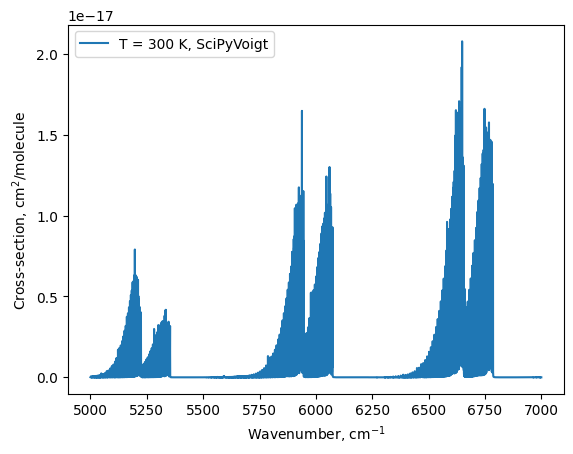

Cross sections plot saved.
Cross sections file saved.
Running time on CPU       : 128.21051622999948 s
Running time on system    : 127.96242880821228 s

The program total running time:
Running time on CPU       : 5840.500068183 s
Running time on system    : 209.49939489364624 s

Finished!


In [61]:
get_results(read_path)